In [11]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

In [12]:
DATA_PATH = "/kaggle/input/power-transformers-fdd-and-rul/"
TRAIN_DATA_DIR = os.path.join(DATA_PATH, "data_train")
TEST_DATA_DIR = os.path.join(DATA_PATH, "data_test")
import kagglehub


path = kagglehub.dataset_download("yuriykatser/power-transformers-fdd-and-rul")

print("Path to dataset files:", path)
TRAIN_FDD_LABELS_PATH = os.path.join(DATA_PATH, "labels_fdd_train.csv")
TRAIN_RUL_LABELS_PATH = os.path.join(DATA_PATH, "labels_rul_train.csv")
TEST_FDD_LABELS_PATH = os.path.join(DATA_PATH, "labels_fdd_test.csv")
TEST_RUL_LABELS_PATH = os.path.join(DATA_PATH, "labels_rul_test.csv")
train_fdd_labels = pd.read_csv(TRAIN_FDD_LABELS_PATH)
train_rul_labels = pd.read_csv(TRAIN_RUL_LABELS_PATH)
test_fdd_labels = pd.read_csv(TEST_FDD_LABELS_PATH)
test_rul_labels = pd.read_csv(TEST_RUL_LABELS_PATH)

train_labels = pd.merge(train_fdd_labels, train_rul_labels, on="id")
test_labels = pd.merge(test_fdd_labels, test_rul_labels, on="id")


def extract_features(timeseries_df: pd.DataFrame) -> pd.Series:
    features = {}

    for col in timeseries_df.columns:
        if not timeseries_df[col].empty:
            mean_val = timeseries_df[col].mean()
            std_val = timeseries_df[col].std()
            features[f'{col}_mean'] = mean_val
            features[f'{col}_std'] = std_val if pd.notna(std_val) else 0
        else:
            features[f'{col}_mean'] = np.nan
            features[f'{col}_std'] = np.nan

    return pd.Series(features)
    
def load_and_process_data(label_df: pd.DataFrame, data_dir: str) -> pd.DataFrame:
    processed_features = []
    ids, fdd_labels, rul_labels = [], [], []

    for _, row in tqdm(label_df.iterrows(), total=len(label_df)):
        file_id = row['id']
        try:
            df = pd.read_csv(os.path.join(data_dir, file_id))
            features = extract_features(df)
            processed_features.append(features)
            ids.append(file_id)
            fdd_labels.append(row['category'])
            rul_labels.append(row['predicted'])
        except:
            continue

    features_df = pd.DataFrame(processed_features)
    features_df['id'] = ids
    features_df['category'] = fdd_labels
    features_df['predicted'] = rul_labels
    return features_df


train_processed_df = load_and_process_data(train_labels, TRAIN_DATA_DIR)
test_processed_df = load_and_process_data(test_labels, TEST_DATA_DIR)

feature_cols = [col for col in train_processed_df.columns if col not in ['id', 'category', 'predicted']]
X_train = train_processed_df[feature_cols].copy()
y_train_fdd = train_processed_df['category'].copy()
y_train_rul= train_processed_df['predicted'].copy()
X_test = test_processed_df[feature_cols].copy()
y_test_fdd = test_processed_df['category'].copy()
y_test_rul= test_processed_df['predicted'].copy()

train_medians = X_train.median()
X_train.fillna(train_medians, inplace=True)
X_test.fillna(train_medians, inplace=True)


Path to dataset files: /kaggle/input/power-transformers-fdd-and-rul


  0%|          | 0/2100 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [13]:
print("Unique Categories:",train_fdd_labels['category'].unique())
print("Value Counts for the categories: ",train_fdd_labels['category'].value_counts())
# y_train_fdd|

Unique Categories: [1 2 4 3]
Value Counts for the categories:  category
1    1705
4     193
3     113
2      89
Name: count, dtype: int64


# Resampling the Data
using SMOTE and SMOTeTomek 

In [9]:
# !pip install --force-reinstall scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Optional: Train-test split before resampling to avoid leakage
X_train_fdd_resam, X_validation_fdd_resam, y_train_fdd_resam, y_validation_fdd_resam = train_test_split(X_train, y_train_fdd, test_size=0.2, random_state=42, stratify=y_train_fdd)

# Apply SMOTE only on training set
sm = SMOTE(random_state=42)
X_fddtrain_resampled, y_fddtrain_resampled = sm.fit_resample(X_train_fdd_resam, y_train_fdd_resam)

print("Original:",  y_train_fdd_resam.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_fddtrain_resampled).value_counts().to_dict())


Original: {1: 1364, 4: 155, 3: 90, 2: 71}
After SMOTE: {4: 1364, 1: 1364, 3: 1364, 2: 1364}


In [21]:
# using GB Classifier
lgb_clf= lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,
    num_leaves=7,      
    learning_rate=0.2,  
    n_estimators=30,    
    max_depth=3,        
    random_state=42
)

lgb_clf.fit(X_fddtrain_resampled,y_fddtrain_resampled)

y_pred_proba = lgb_clf.predict_proba(X_validation_fdd_resam)
y_pred = lgb_clf.predict(X_validation_fdd_resam)

accuracy = accuracy_score(y_validation_fdd_resam, y_pred)
roc_auc_multiclass_ovr = roc_auc_score(y_validation_fdd_resam, y_pred_proba,multi_class='ovr',average='weighted')
f1_multiclass_macro = f1_score(y_validation_fdd_resam, y_pred, average='macro')
f1_multiclass_weighted = f1_score(y_validation_fdd_resam, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc_multiclass_ovr:.4f}")
print(f"F1-score(macro): {f1_multiclass_macro:.4f}")
print(f"F1-score(weighted): {f1_multiclass_weighted:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 5456, number of used features: 8
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Accuracy: 0.9381
ROC-AUC: 0.9854
F1-score(macro): 0.8661
F1-score(weighted): 0.9405


              precision    recall  f1-score   support

           1       0.99      0.95      0.97       341
           2       0.90      1.00      0.95        18
           3       0.68      0.91      0.78        23
           4       0.75      0.79      0.77        38

    accuracy                           0.94       420
   macro avg       0.83      0.91      0.87       420
weighted avg       0.95      0.94      0.94       420



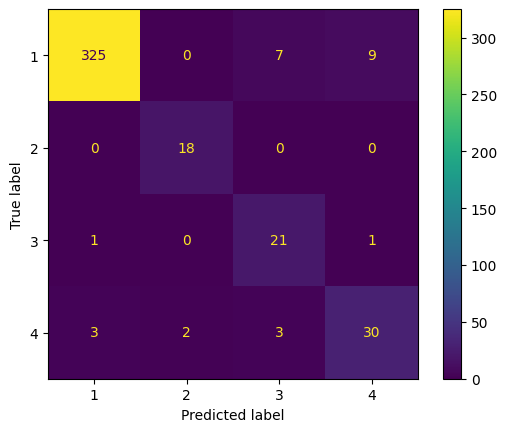

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
print(classification_report(y_validation_fdd_resam,y_pred))
ConfusionMatrixDisplay.from_predictions(y_validation_fdd_resam, y_pred)

### Using LGBMRegressor

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Optional: Train-test split before resampling to avoid leakage
X_train_rulREG, X_validation_rulREG, y_train_rulREG, y_validation_rulREG= train_test_split(X_train, y_train_rul, test_size=0.2, random_state=42)

# Predicting RUL for Transformers
lgb_Reg= lgb.LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=51,      
    learning_rate=0.09,  
    n_estimators=500,    
    max_depth=-1,        
    random_state=42
)
lgb_Reg.fit(X_train_rulREG, y_train_rulREG)
y_pred_rul=lgb_Reg.predict(X_validation_rulREG)

mae = mean_absolute_error(y_validation_rulREG, y_pred_rul)
rmse = np.sqrt(mean_squared_error(y_validation_rulREG, y_pred_rul))
r2 = r2_score(y_validation_rulREG, y_pred_rul)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1680, number of used features: 8
[LightGBM] [Info] Start training from score 785.895238
MAE: 108.56
RMSE: 146.41
R²: 0.64


# Checking OUTLIER in data for RUL Prediction

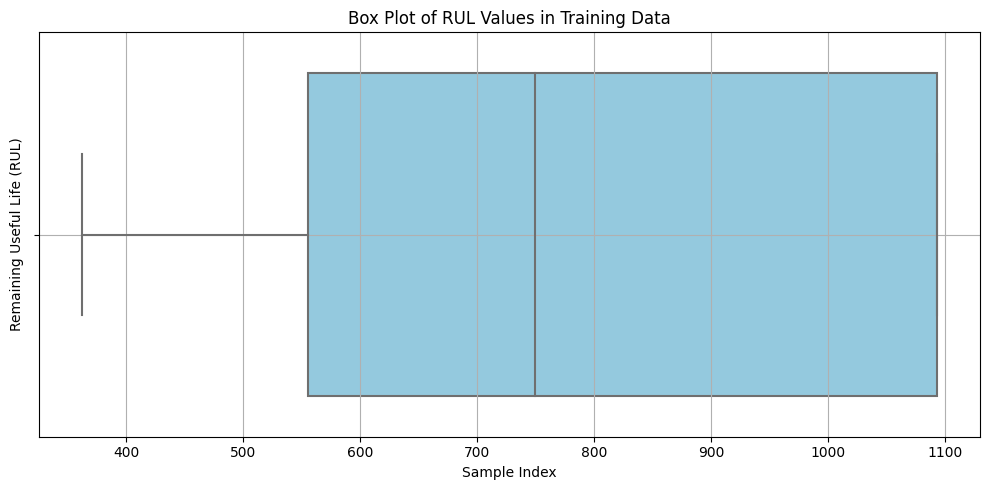

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
# plt.scatter(range(len(y_train_rul)),y_train_rul ,alpha=0.6,color='blue',s=15)
sns.boxplot(x=y_train_rulREG, color='skyblue')
plt.title("Box Plot of RUL Values in Training Data")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Removing Outlier

In [30]:
# Step 1: Convert to DataFrame if needed
df_rul = X_train_rulREG.copy()
df_rul['RUL'] = y_train_rulREG

# Step 2: Calculate IQR bounds
Q1 = df_rul['RUL'].quantile(0.25)
Q3 = df_rul['RUL'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")

# Step 3: Filter out outliers
df_rul_cleaned = df_rul[(df_rul['RUL'] >= lower_bound) & (df_rul['RUL'] <= upper_bound)]

# Step 4: Separate features and target again
X_train_rul_cleaned = df_rul_cleaned.drop(columns=['RUL'])
y_train_rul_cleaned = df_rul_cleaned['RUL']


IQR bounds: -252.00 to 1900.00


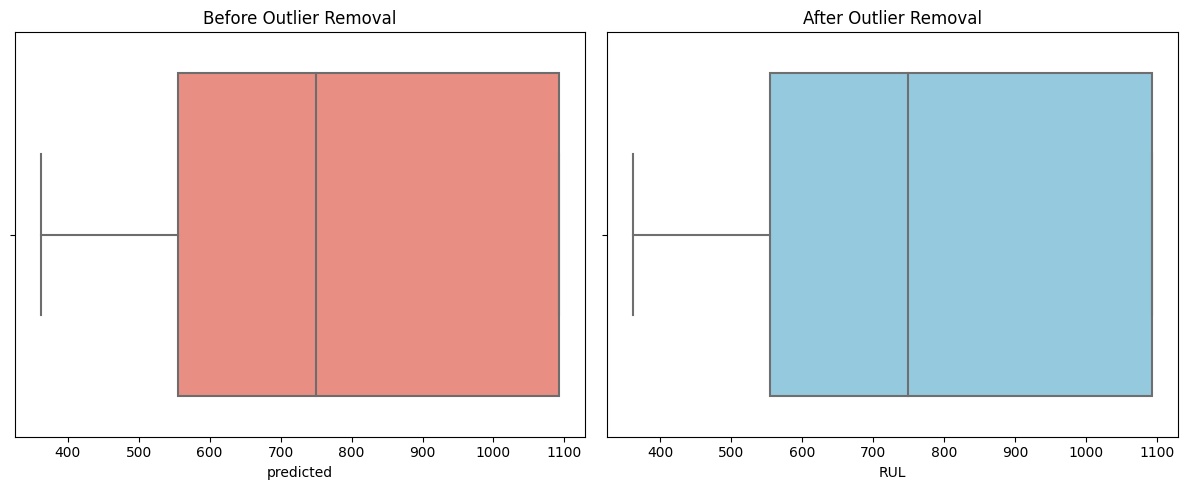

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=y_train_rulREG, color='salmon')
plt.title("Before Outlier Removal")

plt.subplot(1, 2, 2)
sns.boxplot(x=y_train_rul_cleaned, color='skyblue')
plt.title("After Outlier Removal")

plt.tight_layout()
plt.show()


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
}
rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_absolute_error')
grid.fit(X_train_rul_cleaned, y_train_rul_cleaned)
print("Best Params:", grid.best_params_)

Best Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 300}


In [35]:
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=42)
rf.fit(X_train_rul_cleaned, y_train_rul_cleaned)
y_pred_rulrf=rf.predict(X_validation_rulREG)

maeRF = mean_absolute_error(y_validation_rulREG, y_pred_rulrf)
rmseRF = np.sqrt(mean_squared_error(y_validation_rulREG, y_pred_rulrf))
r2RF = r2_score(y_validation_rulREG, y_pred_rulrf)

print(f"MAE: {maeRF:.2f}")
print(f"RMSE: {rmseRF:.2f}")
print(f"R²: {r2RF:.2f}")

MAE: 105.55
RMSE: 139.81
R²: 0.67


In [36]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train_rul_cleaned, y_train_rul_cleaned)
y_pred_rulxgb=xgb.predict(X_validation_rulREG)

maeRF = mean_absolute_error(y_validation_rulREG, y_pred_rulrf)
rmseRF = np.sqrt(mean_squared_error(y_validation_rulREG, y_pred_rulxgb))
r2RF = r2_score(y_validation_rulREG, y_pred_rulxgb)

print(f"MAE: {maeRF:.2f}")
print(f"RMSE: {rmseRF:.2f}")
print(f"R²: {r2RF:.2f}")

MAE: 105.55
RMSE: 143.55
R²: 0.65


In [37]:
columns = [
    'H2_mean', 'H2_std', 'CO_mean', 'CO_std',
    'C2H4_mean', 'C2H4_std', 'C2H2_mean', 'C2H2_std'
]
values=[]
for col in columns:
    while True:
        try:
            value = float(input(f"Enter value for {col}: "))
            values.append(value)
            break  # exit the loop if input is valid
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

df = pd.DataFrame([values], columns=columns)

Enter value for H2_mean:  0.001587
Enter value for H2_std:  0.000339
Enter value for CO_mean:  0.033522,


Invalid input. Please enter a numeric value.


Enter value for CO_mean:   0.003529
Enter value for CO_std:  0.033522
Enter value for C2H4_mean:  0.002054
Enter value for C2H4_std:  0.001062
Enter value for C2H2_mean:  0.000277
Enter value for C2H2_std:  0.000027


values = [
    0.001587, 0.000339, 0.033522, 0.003529,
    0.002054, 0.001062, 0.000277, 0.000027
]


In [38]:
# Classification
class_pred = lgb_clf.predict(df)[0]
class_map={
    1:'Normal class',
    2:'Partial Discharge',
    3:'Low Energy Discharge',
    4:'Low-Temperature Overheating'
}

class_label = class_map.get(class_pred, "Unknown Class")
print("Predicted class:", class_label)
# Regression
reg_pred = rf.predict(df)  # or rf.predict(sample_df)
print("Predicted regression value:", reg_pred[0])

Predicted class: Low-Temperature Overheating
Predicted regression value: 900.893458874459


In [39]:
import joblib
#save models
joblib.dump(lgb_clf,'classifier_model.pkl')
joblib.dump(rf,'regression_model.pkl')

['regression_model.pkl']

In [41]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.2 MB/s eta 0:00:00:00:0100:01
